# 2. Cell Classifier
This note book is for classifying cells in the first BMC data set, annotated by Felicia.

In [1]:
import os
from pathlib import Path
import random
import numpy as np

from skimage.draw import polygon
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import json
import pandas as pd

import utils
from weighted_loss_unet import make_weighted_loss_unet, my_loss

## Investigating data

In [2]:
from dataset import Swebcg
df = Swebcg().get_dataframe()
df['class'].value_counts()

tumor           658
immune cells    593
stroma          421
rbc              30
necrosis          6
Name: class, dtype: int64

In [3]:
# Dropping necrosis and rbc
df = df[df['class'] != 'rbc']
df = df[df['class'] != 'necrosis']

In [4]:
WIDTH = 256
HEIGHT = 256
SHAPE = (WIDTH, HEIGHT)

def normalize_vertices(vertices):
    (x_min,y_min), (_, _) = utils.bounding_box(vertices)
    return [(x - x_min, y - y_min) for x, y in vertices]

def generate_mask(vertices):
    img = Image.new("L", (3000, 3000), 0)
    ImageDraw.Draw(img).polygon(vertices, outline=1, fill=1)
    (left, upper), (right, lower) = utils.bounding_box(vertices)
    img = img.crop((left, upper, right+1, lower+1))
    return np.asarray(img)

df['bounding box'] = df['vertices'].apply(utils.bounding_box)
df['shape'] = df['bounding box'].apply(lambda x: (x[1][1]-x[0][1], x[1][0]-x[0][0]))
df['vertices normalized'] = df['vertices'].apply(normalize_vertices)
df['mask'] = df['vertices'].apply(generate_mask)
df['size'] = df['mask'].apply(np.sum)
df = df[df['size'] != 0]

Text(0.5, 1.0, 'Major and minor axis ratio')

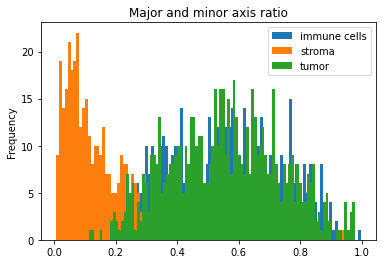

In [5]:
# Exploring major and minor axis
# https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

def major_minor_axis(mask):
    y, x = np.nonzero(mask)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    v2, v1 = np.sort(evals)
    return v1, v2

df['major axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[0])
df['minor axis'] = df['mask'].apply(lambda x: major_minor_axis(x)[1])
df['axis ratio'] = df['minor axis'] / df['major axis']
df.groupby('class')['axis ratio'].plot.hist(bins = 100)
plt.legend()
plt.title('Major and minor axis ratio')

Max size: 39643
Min size: 29


Text(0.5, 1.0, 'Sizes in pixels')

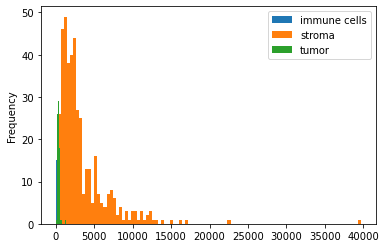

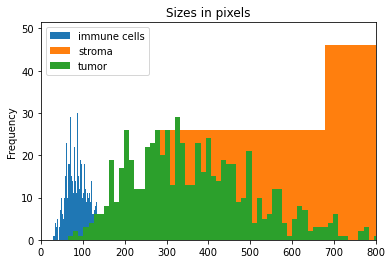

In [6]:
# Size Size varies between classes
print('Max size:', df['size'].max())
print('Min size:', df['size'].min())
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100)
plt.legend()
plt.figure()
df.groupby('class')['size'].plot.hist(bins = 100, xlim=(0, 800))
plt.legend()
plt.title('Sizes in pixels')

## Training basic model
We've found that the axis ratio and size seem to differ. We will use these as features.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import time

features = ['size', 'major axis', 'minor axis']
classes = ['tumor', 'stroma', 'immune cells']
df_class = pd.get_dummies(df['class'])
df_features = pd.concat([df_class, df[features]], axis=1)

np.random.seed(0) # Set random seed for test/train-split
msk = np.random.rand(len(df_features)) < 0.8
df_test = df_features[~msk]
df_train = df_features[msk]

X = df_train[features]
y = df_train[classes]

kf = KFold(n_splits=5,shuffle=True)
kf.split(X)

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)
cm_list = []
for train_index, val_index in kf.split(X):
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_val).argmax(axis=1)
    y_val = y_val.values.argmax(axis=1)
    cm_list.append(confusion_matrix(y_val, y_pred, normalize='true'))


### Evaluation
The validation scores seem pretty promesing.

<AxesSubplot:>

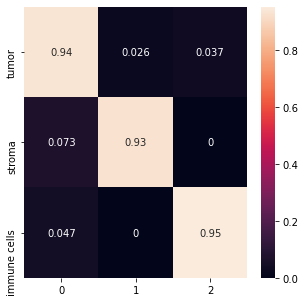

In [9]:
import seaborn as sn
df_cm = pd.DataFrame(np.mean(cm_list, axis=0), index = classes)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)

## Classifying masks predicted by U-Net

In [10]:
import os
import imgaug.augmenters as iaa
import keras
from keras.utils import Sequence
from keras.utils.np_utils import to_categorical   
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from weighted_loss_unet import make_weighted_loss_unet, my_loss

def iou():
    pass

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
BATCH_SIZE = 10

name = 'unet_monuseg'
model_dir = './models/unet'
print("Loading existing model...", end='')
model_unet = keras.models.load_model(f'{model_dir}/{name}.h5',
                    custom_objects={'my_loss' : my_loss, 'iou': iou})
print("Done!")

# Our inference model won't take a weight map as an input.
model_inference = make_weighted_loss_unet((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), 2, False)
model_inference.set_weights(model_unet.get_weights())

Loading existing model...Done!


In [11]:
def _img_to_input(img):
    return np.asarray([img for i in range(BATCH_SIZE)])

from tqdm import tqdm
def make_pred(img, model):
    pred = np.zeros(img.shape[0:2])
    for y in tqdm(range(0, pred.shape[1], IMG_HEIGHT)):
        for x in range(0, pred.shape[0], IMG_WIDTH):
            patch = img[y:y+IMG_HEIGHT,x:x+IMG_WIDTH, :]
            if patch.shape == (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
                pred[y:y+IMG_HEIGHT, x:x+IMG_WIDTH] = model.predict(_img_to_input(patch))[0][...,1]
    
    return pred

img = Swebcg()[0]
pred = make_pred(img, model_inference)

100%|██████████| 27/27 [00:46<00:00,  1.71s/it]


In [13]:
from skimage import morphology

def post_processing(prediction, p = [0.3, 100, 30]):
    prediction = (prediction > p[0])
    prediction = morphology.remove_small_holes(prediction, area_threshold=p[1])
    prediction = morphology.remove_small_objects(prediction, min_size=p[2])
    return prediction

mask = post_processing(pred)

<ipython-input-15-e273228a8c6a>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)


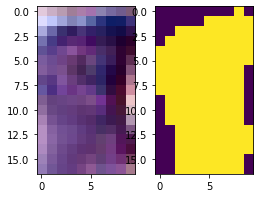

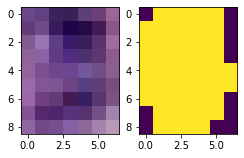

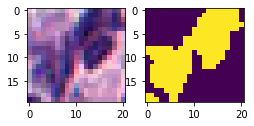

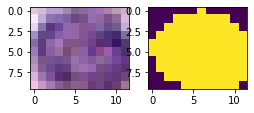

In [15]:
from scipy.ndimage import find_objects
from skimage import measure
from skimage import segmentation

# TODO
#labels = segmentation.random_walker(mask, pred[~mask])

def get_objects(mask):
    all_labels = measure.label(mask, background=0)
    return find_objects(all_labels)

for obj in random.choices(get_objects(mask), k=4):
    plt.figure()
    plt.subplot(131)
    plt.imshow(img[obj])
    plt.subplot(132)
    plt.imshow(pred[obj])
    plt.subplot(132)
    plt.imshow(mask[obj])
    
df_pred = pd.DataFrame([{"mask" : np.array(mask[obj], dtype=np.int),
                        "obj" : obj} for obj in get_objects(mask)])

In [16]:
df_pred['size'] = df_pred['mask'].apply(np.sum)
df_pred['major axis'] = df_pred['mask'].apply(lambda x: major_minor_axis(x)[0])
df_pred['minor axis'] = df_pred['mask'].apply(lambda x: major_minor_axis(x)[1])
df_pred['axis ratio'] = df_pred['minor axis'] / df_pred['major axis']

In [17]:
X = df_pred[features]

def one_hot_to_class(arr):
    try:
        return classes[np.where(arr == 1)[0][0]]
    except:
        return "none"

        
df_pred["class"] = [one_hot_to_class(k) for k in model.predict(X.iloc[:])]
df_pred["class"].value_counts()

immune cells    5144
tumor           4837
stroma           694
none              36
Name: class, dtype: int64

In [42]:
def _bbox_to_slice(bbox):
    return (slice(int(bbox[0][1]), int(bbox[1][1]), None), 
            slice(int(bbox[0][0]), int(bbox[1][0]), None))